# 10X genomics data

This tutorials shows how to annotate pathway data from a 10x Genomics Single-Cell dataset. In this tutorial, the data being used is the same in the scanpy [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) tutorial.

In [1]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: cannot create directory ‘data’: File exists
--2021-07-23 22:22:14--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 2606:4700::6812:ad, 2606:4700::6812:1ad, 104.18.1.173, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:ad|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-07-23 22:22:14--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:ad|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7,3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7,27M  5,10MB/s    in 1,4s    



In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

## Following scanpy tutorial

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  
    var_names='gene_symbols',                
    cache=True)                              

In [4]:
adata.var_names_make_unique()  

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/joao/miniconda3/envs/descartes-rpa/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [7]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [8]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

## Reactome pathway analysis

Here we import the 'get_pathways_for_group' function to annotated pathways for each cluster.

In [9]:
from descartes_rpa import get_pathways_for_group

In [10]:
get_pathways_for_group(adata, groupby="leiden")

In [11]:
from descartes_rpa.pl import marker_genes

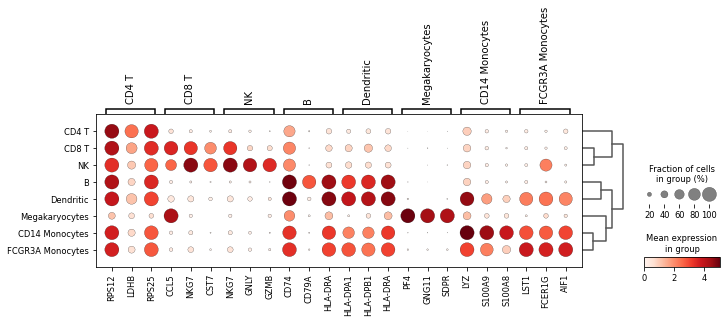

In [12]:
marker_genes(adata, n_genes=3)

In [13]:
from descartes_rpa.pl import pathways

In [14]:
pathways(adata, "Megakaryocytes")

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…